# Fantasy Football Projections - Data Validation

This notebook validates the scraped projection data from multiple sources.

## Setup


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from database import ProjectionsDB

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✓ Imports successful!")


✓ Imports successful!


## 1. Database Overview

Let's start by checking what data we have in the database.


In [3]:
# Connect to database and load all projections
with ProjectionsDB() as db:
    all_projections = db.get_projections()

df = pd.DataFrame(all_projections)

print(f"Total Records: {len(df)}")
print(f"\nDatabase Schema:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.to_csv('all_projections.csv', index=False)
df

Total Records: 1269

Database Schema:
id                     int64
source_website        object
week                  object
player_first_name     object
player_last_name      object
position              object
projected_points     float64
created_at            object
updated_at            object
team                  object
dtype: object

First few rows:


,id,source_website,week,player_first_name,player_last_name,position,projected_points,created_at,updated_at,team
0,7254,espn.com,Week 9,Christian,McCaffrey,RB,26.10,2025-10-29 00:31:33,2025-10-29 00:31:33,SF
1,6837,sleeper.com,Week 9,Josh,Allen,QB,26.00,2025-10-29 00:23:43,2025-10-29 00:23:43,BUF
2,6838,sleeper.com,Week 9,Lamar,Jackson,QB,25.60,2025-10-29 00:23:43,2025-10-29 00:23:43,BAL
3,7459,fantasypros.com,Week 8,Patrick,Mahomes II,QB,25.00,2025-10-29 00:39:00,2025-10-29 00:39:00,KC
4,8106,fanduel.com,Week 9,Lamar,Jackson,QB,24.73,2025-10-29 00:52:31,2025-10-29 00:52:31,BAL
...,...,...,...,...,...,...,...,...,...,...
1264,8566,fanduel.com,Week 9,Tip,Reiman,TE,0.00,2025-10-29 00:52:31,2025-10-29 00:52:31,ARI
1265,8567,fanduel.com,Week 9,Xavier,Weaver,WR,0.00,2025-10-29 00:52:31,2025-10-29 00:52:31,ARI
1266,8568,fanduel.com,Week 9,Travis,Vokolek,TE,0.00,2025-10-29 00:52:31,2025-10-29 00:52:31,ARI
1267,8569,fanduel.com,Week 9,Jalen,Cropper,WR,0.00,2025-10-29 00:52:31,2025-10-29 00:52:31,DAL


### Where Team is null

In [48]:
null_team_df = df[df['team'].isnull()]
#null_team_df = null_team_df[null_team_df['source_website'] == 'fantasypros.com']
null_team_df.to_csv('null_team_df.csv', index=False)
null_team_df

,id,source_website,week,player_first_name,player_last_name,position,projected_points,created_at,updated_at,team


In [70]:
fa_team_df = df[df['player_first_name'] == "Christian"]
fa_team_df

,id,source_website,week,player_first_name,player_last_name,position,projected_points,created_at,updated_at,team
0,7254,espn.com,Week 9,Christian,McCaffrey,RB,26.10,2025-10-29 00:31:33,2025-10-29 00:31:33,SF
16,7642,fanduel.com,Week 9,Christian,McCaffrey,RB,22.79,2025-10-29 00:49:07,2025-10-29 00:49:07,SF
45,7516,fantasypros.com,Week 8,Christian,McCaffrey,RB,20.00,2025-10-29 00:39:00,2025-10-29 00:39:00,SF
444,6951,sleeper.com,Week 9,Christian,Watson,WR,9.50,2025-10-29 00:23:43,2025-10-29 00:23:43,GB
469,7754,fanduel.com,Week 9,Christian,Kirk,WR,9.11,2025-10-29 00:49:07,2025-10-29 00:49:07,HOU
511,7766,fanduel.com,Week 9,Christian,Watson,WR,8.52,2025-10-29 00:49:07,2025-10-29 00:49:07,GB


## 2. Data Source Breakdown

Check how many projections we have from each source.


In [49]:
# Count by source
print("Projections by Source:")
print("=" * 50)
source_counts = df['source_website'].value_counts()
print(source_counts)
print(f"\nTotal Sources: {df['source_website'].nunique()}")

# Count by week
print("\n\nProjections by Week:")
print("=" * 50)
week_counts = df['week'].value_counts()
print(week_counts)

# Count by source and week
print("\n\nProjections by Source and Week:")
print("=" * 50)
source_week = df.groupby(['source_website', 'week']).size().reset_index(name='count')
print(source_week)


Projections by Source:
source_website
sleeper.com    389
espn.com       233
Name: count, dtype: int64

Total Sources: 2


Projections by Week:
week
Week 9    622
Name: count, dtype: int64


Projections by Source and Week:
  source_website    week  count
0       espn.com  Week 9    233
1    sleeper.com  Week 9    389


## 3. Position Breakdown

Verify that positions are stored correctly (no numbers, just position names).


In [4]:
# Count by position
print("Projections by Position:")
print("=" * 50)
position_counts = df['position'].value_counts()
print(position_counts)

# Check for any positions with numbers (should be none)
print("\n\nValidation: Checking for positions with numbers...")
positions_with_numbers = df[df['position'].str.contains(r'\d', na=False)]
if len(positions_with_numbers) > 0:
    print(f"⚠ WARNING: Found {len(positions_with_numbers)} positions with numbers!")
    print(positions_with_numbers[['player_first_name', 'player_last_name', 'position', 'source_website']])
else:
    print("✓ All positions are clean (no numbers)")

# Position breakdown by source
print("\n\nPosition Breakdown by Source:")
print("=" * 50)
pos_by_source = pd.crosstab(df['position'], df['source_website'])
print(pos_by_source)


Projections by Position:
position
WR    52
RB    38
TE    25
.     24
       4
Name: count, dtype: int64


Validation: Checking for positions with numbers...
✓ All positions are clean (no numbers)


Position Breakdown by Source:
source_website  firstdown.studio
position                        
                               4
.                             24
RB                            38
TE                            25
WR                            52


## 4. Data Quality Checks

Check for missing values, duplicates, and data integrity issues.


In [5]:
# Check for missing values
print("Missing Values Check:")
print("=" * 50)
missing = df.isnull().sum()
print(missing)

if missing.sum() > 0:
    print("\n⚠ WARNING: Found missing values!")
else:
    print("\n✓ No missing values")

# Check for empty strings in names
print("\n\nEmpty Name Check:")
print("=" * 50)
empty_first = df[df['player_first_name'] == '']
empty_last = df[df['player_last_name'] == '']
print(f"Players with empty first name: {len(empty_first)}")
print(f"Players with empty last name: {len(empty_last)}")

if len(empty_first) > 0:
    print("\nPlayers with empty first name:")
    print(empty_first[['player_first_name', 'player_last_name', 'position', 'source_website']])

# Check for duplicates (same player, source, week, position)
print("\n\nDuplicate Check:")
print("=" * 50)
duplicates = df.duplicated(subset=['source_website', 'week', 'player_first_name', 'player_last_name', 'position'], keep=False)
dup_count = duplicates.sum()
print(f"Duplicate records: {dup_count}")

if dup_count > 0:
    print("\n⚠ WARNING: Found duplicates!")
    dup_df = df[duplicates].sort_values(['player_first_name', 'player_last_name', 'source_website'])
    print(dup_df[['player_first_name', 'player_last_name', 'position', 'source_website', 'week', 'projected_points']])
else:
    print("✓ No duplicates found")

# Check projected points range
print("\n\nProjected Points Statistics:")
print("=" * 50)
print(df['projected_points'].describe())

# Check for unrealistic values
print("\n\nUnrealistic Values Check:")
print("=" * 50)
zero_points = df[df['projected_points'] == 0]
negative_points = df[df['projected_points'] < 0]
very_high_points = df[df['projected_points'] > 50]

print(f"Players with 0 projected points: {len(zero_points)}")
print(f"Players with negative points: {len(negative_points)}")
print(f"Players with >50 projected points: {len(very_high_points)}")

if len(negative_points) > 0:
    print("\n⚠ WARNING: Found negative projections!")
    print(negative_points[['player_first_name', 'player_last_name', 'position', 'projected_points', 'source_website']])


Missing Values Check:
id                   0
source_website       0
week                 0
player_first_name    0
player_last_name     0
position             0
projected_points     0
created_at           0
updated_at           0
dtype: int64

✓ No missing values


Empty Name Check:
Players with empty first name: 0
Players with empty last name: 0


Duplicate Check:
Duplicate records: 0
✓ No duplicates found


Projected Points Statistics:
count    143.000000
mean      11.970629
std        4.186999
min        4.700000
25%        8.500000
50%       11.700000
75%       14.400000
max       23.800000
Name: projected_points, dtype: float64


Unrealistic Values Check:
Players with 0 projected points: 0
Players with negative points: 0
Players with >50 projected points: 0


## 5. Top Players by Position

View the top projected players for each position.


In [19]:
# Create full name column for easier reading
df['player_name'] = df['player_first_name'] + ' ' + df['player_last_name']

# Top players by position (showing both sources if available)
positions = ['QB', 'RB', 'WR', 'TE']

for pos in positions:
    print(f"\n{pos} - Top 10 Projections:")
    print("=" * 80)
    pos_df = df[df['position'] == pos].sort_values('projected_points', ascending=False).head(10)
    print(pos_df[['player_name', 'source_website', 'projected_points', 'week']].to_string(index=False))
    print()



QB - Top 10 Projections:
    player_name source_website  projected_points   week
     Josh Allen    fanduel.com             22.24 Week 8
    Jalen Hurts    fanduel.com             21.13 Week 8
Patrick Mahomes    fanduel.com             21.10 Week 8
 Baker Mayfield    fanduel.com             20.05 Week 8
         Bo Nix    fanduel.com             20.02 Week 8
 Justin Herbert    fanduel.com             19.91 Week 8
     Drake Maye    fanduel.com             19.09 Week 8
   Daniel Jones    fanduel.com             18.63 Week 8
   Dak Prescott    fanduel.com             18.16 Week 8
    Jordan Love    fanduel.com             17.48 Week 8


RB - Top 10 Projections:
        player_name   source_website  projected_points   week
    Jonathan Taylor      fanduel.com             24.62 Week 8
     Bijan Robinson firstdown.studio             23.80 Week 8
Christian McCaffrey      fanduel.com             23.04 Week 8
     Bijan Robinson      fanduel.com             22.86 Week 8
    Jonathan Taylor f

## 6. Cross-Source Player Matching

Check which players have projections from multiple sources.


In [7]:
# Find players with projections from multiple sources
player_sources = df.groupby(['player_first_name', 'player_last_name', 'position'])['source_website'].nunique().reset_index()
player_sources.columns = ['first_name', 'last_name', 'position', 'num_sources']

multi_source = player_sources[player_sources['num_sources'] > 1]
single_source = player_sources[player_sources['num_sources'] == 1]

print(f"Players with projections from multiple sources: {len(multi_source)}")
print(f"Players with projections from single source: {len(single_source)}")
print(f"Total unique players: {len(player_sources)}")

print("\n\nSample Multi-Source Players:")
print("=" * 80)
multi_source_sample = multi_source.sample(min(10, len(multi_source)))
for _, row in multi_source_sample.iterrows():
    player_name = f"{row['first_name']} {row['last_name']}"
    player_projs = df[(df['player_first_name'] == row['first_name']) & 
                      (df['player_last_name'] == row['last_name']) & 
                      (df['position'] == row['position'])]
    print(f"\n{player_name} ({row['position']}):")
    for _, proj in player_projs.iterrows():
        print(f"  {proj['source_website']}: {proj['projected_points']:.1f} pts")


Players with projections from multiple sources: 0
Players with projections from single source: 143
Total unique players: 143


Sample Multi-Source Players:


## 7. Projection Comparison Between Sources

Compare projections for players who appear in multiple sources.


In [8]:
# Get multi-source players with their projections
multi_source_players = multi_source.merge(df, 
                                          left_on=['first_name', 'last_name', 'position'],
                                          right_on=['player_first_name', 'player_last_name', 'position'])

# Calculate difference for each player
comparison_list = []
for _, player in multi_source[multi_source['num_sources'] == 2].iterrows():
    player_projs = df[(df['player_first_name'] == player['first_name']) & 
                      (df['player_last_name'] == player['last_name']) & 
                      (df['position'] == player['position'])]
    
    if len(player_projs) == 2:
        proj_values = player_projs['projected_points'].values
        sources = player_projs['source_website'].values
        diff = abs(proj_values[0] - proj_values[1])
        avg = (proj_values[0] + proj_values[1]) / 2
        
        comparison_list.append({
            'player_name': f"{player['first_name']} {player['last_name']}",
            'position': player['position'],
            'source1': sources[0],
            'proj1': proj_values[0],
            'source2': sources[1],
            'proj2': proj_values[1],
            'difference': diff,
            'average': avg,
            'pct_diff': (diff / avg * 100) if avg > 0 else 0
        })

if comparison_list:
    comparison_df = pd.DataFrame(comparison_list)
    comparison_df = comparison_df.sort_values('difference', ascending=False)
    
    print(f"Players with projections from exactly 2 sources: {len(comparison_df)}")
    print("\n\nProjection Comparison Statistics:")
    print("=" * 80)
    print(f"Average difference: {comparison_df['difference'].mean():.2f} points")
    print(f"Median difference: {comparison_df['difference'].median():.2f} points")
    print(f"Max difference: {comparison_df['difference'].max():.2f} points")
    print(f"Average % difference: {comparison_df['pct_diff'].mean():.1f}%")
    
    print("\n\nTop 10 Biggest Projection Differences:")
    print("=" * 80)
    print(comparison_df.head(10)[['player_name', 'position', 'proj1', 'proj2', 'difference', 'pct_diff']].to_string(index=False))
else:
    print("No players found with projections from exactly 2 sources")


No players found with projections from exactly 2 sources


## 8. Visualizations

Create some charts to visualize the data.


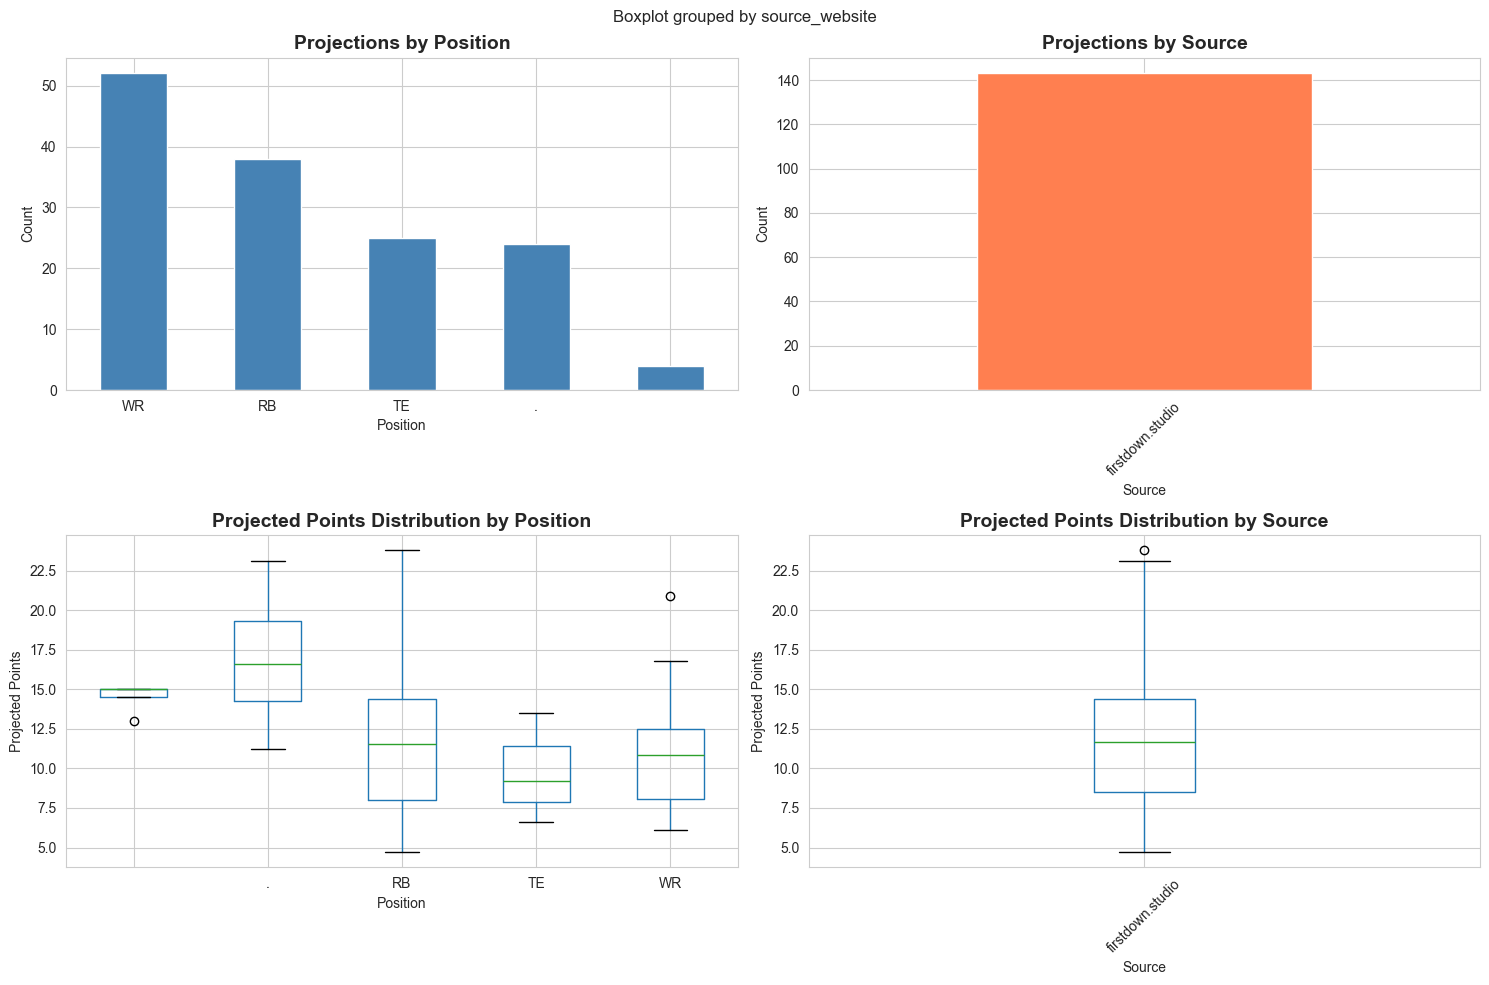

✓ Visualizations generated


In [9]:
# Set style
sns.set_style("whitegrid")

# 1. Projections by Position and Source
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Position counts
ax1 = axes[0, 0]
position_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Projections by Position', fontsize=14, fontweight='bold')
ax1.set_xlabel('Position')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Source counts
ax2 = axes[0, 1]
source_counts.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Projections by Source', fontsize=14, fontweight='bold')
ax2.set_xlabel('Source')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Projected points distribution by position
ax3 = axes[1, 0]
df.boxplot(column='projected_points', by='position', ax=ax3)
ax3.set_title('Projected Points Distribution by Position', fontsize=14, fontweight='bold')
ax3.set_xlabel('Position')
ax3.set_ylabel('Projected Points')
plt.sca(ax3)
plt.xticks(rotation=0)

# Projected points distribution by source
ax4 = axes[1, 1]
df.boxplot(column='projected_points', by='source_website', ax=ax4)
ax4.set_title('Projected Points Distribution by Source', fontsize=14, fontweight='bold')
ax4.set_xlabel('Source')
ax4.set_ylabel('Projected Points')
plt.sca(ax4)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("✓ Visualizations generated")


In [10]:
# Projection differences scatter plot (if we have comparison data)
if comparison_list and len(comparison_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scatter plot of projections
    ax1 = axes[0]
    for pos in ['QB', 'RB', 'WR', 'TE']:
        pos_data = comparison_df[comparison_df['position'] == pos]
        ax1.scatter(pos_data['proj1'], pos_data['proj2'], label=pos, alpha=0.6, s=50)
    
    # Add diagonal line (perfect agreement)
    max_val = max(comparison_df['proj1'].max(), comparison_df['proj2'].max())
    ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Perfect Agreement')
    
    ax1.set_xlabel(f'{comparison_df["source1"].iloc[0]} Projections', fontsize=12)
    ax1.set_ylabel(f'{comparison_df["source2"].iloc[0]} Projections', fontsize=12)
    ax1.set_title('Source Projection Comparison', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Histogram of differences
    ax2 = axes[1]
    ax2.hist(comparison_df['difference'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Projection Difference (points)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Projection Differences', fontsize=14, fontweight='bold')
    ax2.axvline(comparison_df['difference'].mean(), color='red', linestyle='--', 
                label=f'Mean: {comparison_df["difference"].mean():.2f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Comparison visualizations generated")
else:
    print("Not enough multi-source data for comparison visualizations")


Not enough multi-source data for comparison visualizations


## 9. Custom Queries

Add your own custom queries here to explore the data further.


In [11]:
# Example: Search for a specific player
player_search = "Robinson"  # Change this to search for different players

print(f"Searching for players with '{player_search}' in their name:")
print("=" * 80)
search_results = df[
    df['player_first_name'].str.contains(player_search, case=False, na=False) | 
    df['player_last_name'].str.contains(player_search, case=False, na=False)
]

if len(search_results) > 0:
    print(search_results[['player_name', 'position', 'source_website', 'projected_points', 'week']].sort_values('projected_points', ascending=False))
else:
    print(f"No players found matching '{player_search}'")


Searching for players with 'Robinson' in their name:
       player_name position    source_website  projected_points    week
0   Bijan Robinson       RB  firstdown.studio              23.8  Week 8
84     W. Robinson       WR  firstdown.studio              10.8  Week 8


In [12]:
# Example: Get projections for a specific week and position
week_filter = "Week 8"  # Change as needed
position_filter = "RB"  # Change as needed

print(f"\n{position_filter} Projections for {week_filter}:")
print("=" * 80)
filtered = df[(df['week'] == week_filter) & (df['position'] == position_filter)].sort_values('projected_points', ascending=False)

# Show top 20
print(filtered.head(20)[['player_name', 'source_website', 'projected_points']].to_string(index=False))



RB Projections for Week 8:
     player_name   source_website  projected_points
  Bijan Robinson firstdown.studio              23.8
 Jonathan Taylor firstdown.studio              21.5
    C. McCaffrey firstdown.studio              21.3
   De'Von Achane firstdown.studio              17.9
  Saquon Barkley firstdown.studio              17.4
     Josh Jacobs firstdown.studio              16.2
   Rachaad White firstdown.studio              16.2
      James Cook firstdown.studio              15.7
   Derrick Henry firstdown.studio              15.3
Javonte Williams firstdown.studio              14.4
     Breece Hall firstdown.studio              14.3
    Cam Skattebo firstdown.studio              14.2
   Jaylen Warren firstdown.studio              13.5
    Kimani Vidal firstdown.studio              13.2
     Chase Brown firstdown.studio              13.2
    Alvin Kamara firstdown.studio              13.2
Quinshon Judkins firstdown.studio              12.9
    J.K. Dobbins firstdown.studio   

## 10. Summary Report

Final validation summary.


In [13]:
print("=" * 80)
print("DATA VALIDATION SUMMARY")
print("=" * 80)

print(f"\n📊 Overall Statistics:")
print(f"  • Total Projections: {len(df)}")
print(f"  • Unique Players: {len(player_sources)}")
print(f"  • Data Sources: {df['source_website'].nunique()}")
print(f"  • Weeks: {df['week'].nunique()}")
print(f"  • Positions: {df['position'].nunique()}")

print(f"\n✓ Data Quality:")
print(f"  • Missing Values: {'None ✓' if missing.sum() == 0 else f'{missing.sum()} ⚠'}")
print(f"  • Duplicates: {'None ✓' if dup_count == 0 else f'{dup_count} ⚠'}")
print(f"  • Position Format: {'Clean ✓' if len(positions_with_numbers) == 0 else 'Issues ⚠'}")
print(f"  • Negative Projections: {'None ✓' if len(negative_points) == 0 else f'{len(negative_points)} ⚠'}")

print(f"\n🔍 Multi-Source Coverage:")
print(f"  • Players in Multiple Sources: {len(multi_source)}")
print(f"  • Players in Single Source: {len(single_source)}")
if len(multi_source) > 0:
    coverage_pct = (len(multi_source) / len(player_sources)) * 100
    print(f"  • Multi-Source Coverage: {coverage_pct:.1f}%")

print(f"\n📈 Projection Range:")
print(f"  • Minimum: {df['projected_points'].min():.1f}")
print(f"  • Maximum: {df['projected_points'].max():.1f}")
print(f"  • Average: {df['projected_points'].mean():.1f}")
print(f"  • Median: {df['projected_points'].median():.1f}")

print("\n" + "=" * 80)
print("✓ Validation Complete!")
print("=" * 80)


DATA VALIDATION SUMMARY

📊 Overall Statistics:
  • Total Projections: 143
  • Unique Players: 143
  • Data Sources: 1
  • Weeks: 1
  • Positions: 5

✓ Data Quality:
  • Missing Values: None ✓
  • Duplicates: None ✓
  • Position Format: Clean ✓
  • Negative Projections: None ✓

🔍 Multi-Source Coverage:
  • Players in Multiple Sources: 0
  • Players in Single Source: 143

📈 Projection Range:
  • Minimum: 4.7
  • Maximum: 23.8
  • Average: 12.0
  • Median: 11.7

✓ Validation Complete!
